In [1]:
pip install transformers datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
from datasets import load_dataset

dataset = load_dataset("jeffnyman/emotions")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset emotions downloaded and prepared to /root/.cache/huggingface/datasets/jeffnyman___emotions/split/1.0.0/6beca17f26eb017bb98d323e37c70d7d7f157f3d15a6a12c2e4cf7aa7cbef5a5. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Convert dataset to a pandas dataframe for the sake of Exploratory Data Analysis
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [6]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
train_df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


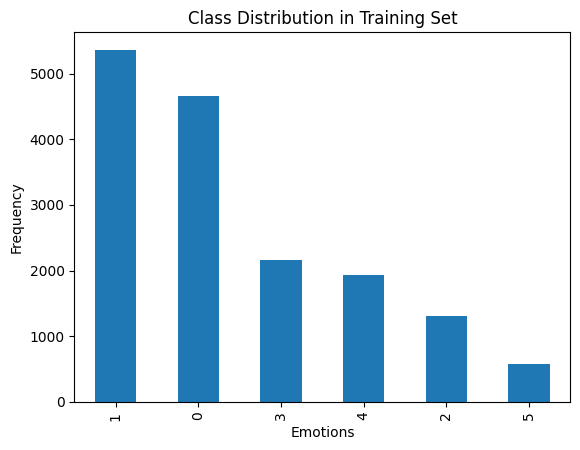

In [8]:
train_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution in Training Set')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.show()

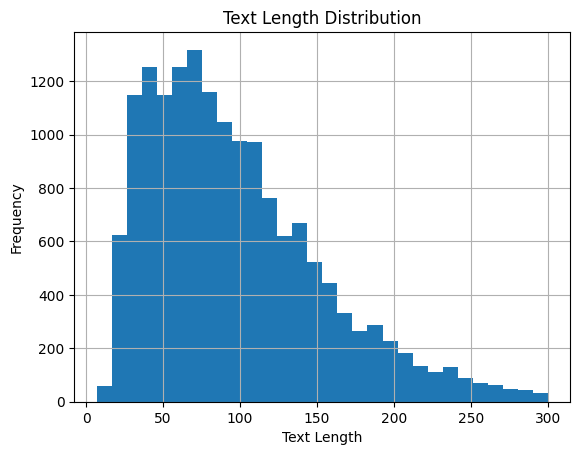

Common words in the dataset: [('i', 25859), ('feel', 11183), ('and', 9589), ('to', 8972), ('the', 8370), ('a', 6200), ('feeling', 5112), ('that', 5112), ('of', 4990), ('my', 4283)]


In [9]:
train_df['text_length'] = train_df['text'].apply(len)

train_df['text_length'].hist(bins=30)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

from collections import Counter
import string

all_text = ' '.join(train_df['text'])

all_text = all_text.translate(str.maketrans('', '', string.punctuation))

word_counts = Counter(all_text.split())
common_words = word_counts.most_common(10)

print("Common words in the dataset:", common_words)

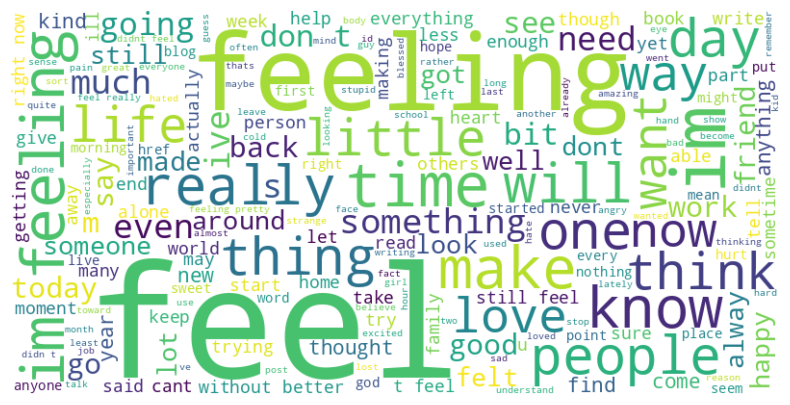

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [12]:
from transformers import AutoModelForSequenceClassification

# Adjust the num_labels according to your dataset specifics
num_labels = len(set(dataset['train']['label']))
model = AutoModelForSequenceClassification.from_pretrained('huawei-noah/TinyBERT_General_4L_312D', num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [17]:
import numpy as np

In [14]:
from datasets import load_metric

accuracy_metric = load_metric("accuracy")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [15]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./tinybert_emotion/',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],  # Assuming 'test' split is available for evaluation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


2024-05-29 06:17:54.963612: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 06:17:54.963716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 06:17:55.059155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be remov

Step,Training Loss
500,1.307500
1000,0.616400
1500,0.320800
2000,0.205200
2500,0.161100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=2500, training_loss=0.5221812225341796, metrics={'train_runtime': 273.9403, 'train_samples_per_second': 292.034, 'train_steps_per_second': 9.126, 'total_flos': 573713694720000.0, 'train_loss': 0.5221812225341796, 'epoch': 5.0})

In [18]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.20588840544223785, 'eval_accuracy': 0.9235, 'eval_runtime': 3.167, 'eval_samples_per_second': 631.519, 'eval_steps_per_second': 5.052, 'epoch': 5.0}


In [19]:
trainer.save_model("./tinybert_emotion_final/")

In [20]:
import os
import zipfile

def zip_model(model_directory, output_filename):
    # Create a Zip file
    with zipfile.ZipFile(output_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the model directory
        for root, dirs, files in os.walk(model_directory):
            for file in files:
                # Create a relative path for files to keep the directory structure
                relative_path = os.path.relpath(os.path.join(root, file), os.path.join(model_directory, '..'))
                zipf.write(os.path.join(root, file), relative_path)

# Usage
model_directory = './tinybert_emotion_final/'  # The directory where your model weights are stored
output_filename = '/kaggle/working/tinybert_emotion_final.zip'  # Output zip file name and path
zip_model(model_directory, output_filename)